Thursday, June 15, 2023

docker container start sad_nightingale

[Building makemore Part 5: Building a WaveNet](https://www.youtube.com/watch?v=t3YJ5hKiMQ0)

[WaveNet: A Generative Model for Raw Audio](https://arxiv.org/abs/1609.03499)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
useGPU = False
if torch.cuda.is_available() and useGPU:
    device = torch.device("cuda")  # Use GPU
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    device = torch.device("cpu")  # Fallback to CPU if GPU is not available
device

device(type='cpu')

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
lenOfWords = len(words)
print(lenOfWords)
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
delimiter = '.'
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi[delimiter] = 0
itos = { c:i for i, c in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + delimiter:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
thgttg = 42
manualSeed = 2147483647

In [7]:
import random
random.seed(thgttg)
random.shuffle(words)

n1 = int(0.8 * lenOfWords)
n2 = int(0.9 * lenOfWords)
print(n1, n2)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

25626 28829
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [9]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [10]:
torch.manual_seed(42)

In [11]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))

layers = [
    
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
]

In [12]:
# parameter initialization
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

In [13]:
parameters = [C] + [p for layer in  layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

12097


In [14]:
for p in parameters:
    p.requires_grad = True

#### Training Loop 1

In [15]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326
CPU times: user 18min 10s, sys: 1.41 s, total: 18min 12s
Wall time: 2min 22s


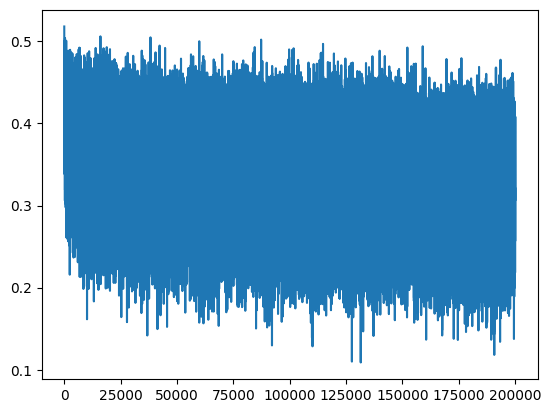

In [16]:
plt.plot(lossi)

In [17]:
# put layers into eval mode (needed for batchnorm especially)
# notice as of right now this only applys to BatchNorn1d
for layer in layers:
    layer.training = False

#### Evaluate the Loss 1

In [18]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

In [19]:
split_loss('train')
split_loss('val')

train 2.0583252906799316
val 2.1065289974212646


#### Sample from the model 1

In [20]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:

        # forward pass the neural net
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, then break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ivon.
fanili.
thoommara.
kelo.
matyn.
leandr.
aleigh.
koldeniah.
prus.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.


#### Let's fix the learning rate plot

In [21]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

Each row is 1000 consecutive elements in the lossi list. 

We can take the mean of each row, and we can then plot that:

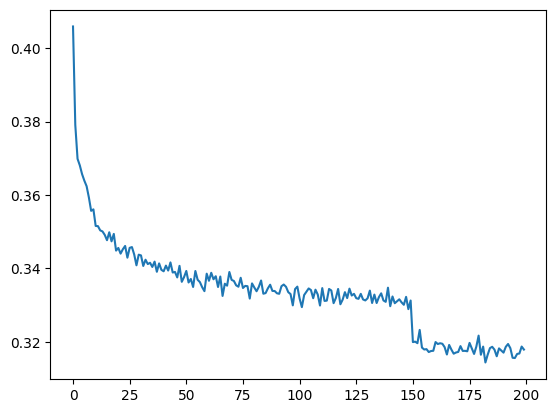

In [22]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

#### PyTorch-ifying our code

Right now our embedding layer is not part of our stack of layers and neither is the concatenation of the tensor. Let's fix that.

![](images/part5_cnn_emb.png)

In [23]:
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
        
    def parameters(self):
        return [self.weight]

In [24]:
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

So now we can add these 2 new layers to our layers collection and take out C.

In [25]:
# our new layers collection
layers = [

    Embedding(vocab_size, n_embd),
    Flatten(),
    
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
]

Our parameters collection no longer needs C, so let's redefine it.

In [26]:
parameters = [p for layer in  layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))

12097


#### Training Loop 2

We need a new training loop.

In [27]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) forward pass ... the only changes from Training Loop 1
    # emb = C[Xb] # embed the characters into vectors
    # x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # for layer in layers:
    #     x = layer(x)
    x = Xb
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # let's break after the first pass ...
    break

      0/ 200000: 3.3711
CPU times: user 256 ms, sys: 3 µs, total: 256 ms
Wall time: 48.7 ms


Right now, layers is a simple list. PyTorch has a container for neural network layers (or modules) called [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

Let's implement our own simpler version of Sequential.

In [28]:
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and strech them out into one list
        return [p for layer in self.layers for p in layer.parameters()]
    

So now we no longer need out naked list of layers. We can add the layers to our Sequential collection and create a model object.

In [29]:
model = Sequential([

    Embedding(vocab_size, n_embd),
    Flatten(),
    
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

We can now just assign model.parameters() to parameters.

In [30]:
# parameters = [p for layer in  layers for p in layer.parameters()]
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))

12097


#### Training Loop 3

Yup, redefine ... but this time actually train the model.

In [31]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) Forward pass
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.4588
  10000/ 200000: 2.4970
  20000/ 200000: 1.9907
  30000/ 200000: 2.2633
  40000/ 200000: 1.8886
  50000/ 200000: 2.4480
  60000/ 200000: 2.0484
  70000/ 200000: 2.3522
  80000/ 200000: 2.5167
  90000/ 200000: 2.3950
 100000/ 200000: 2.3140
 110000/ 200000: 2.3101
 120000/ 200000: 2.3677
 130000/ 200000: 2.0688
 140000/ 200000: 2.5567
 150000/ 200000: 1.7162
 160000/ 200000: 2.0777
 170000/ 200000: 2.3064
 180000/ 200000: 2.1290
 190000/ 200000: 1.7656
CPU times: user 18min 1s, sys: 1.35 s, total: 18min 3s
Wall time: 2min 21s


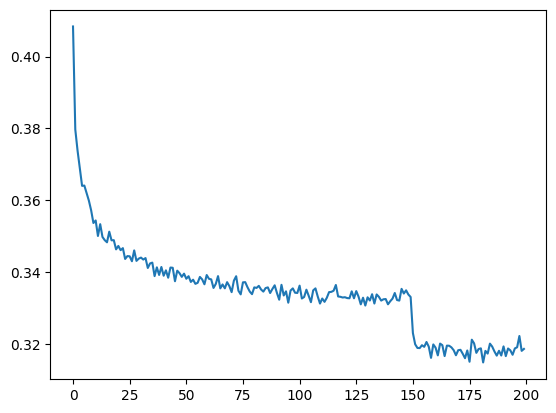

In [32]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

In [33]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

#### Evaluate the Loss 2

In [34]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    # emb = C[x] # (N, block_size, n_embd)
    # x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    # for layer in layers:
    #     x = layer(x)
    logits = model(x)
    # loss = F.cross_entropy(x, y)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [35]:
split_loss('train')
split_loss('val')

train 2.061826229095459
val 2.1066930294036865


#### Sample from the model 2

In [36]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:

        # forward pass the neural net
        # emb = C[torch.tensor([context])]
        # x = emb.view(emb.shape[0], -1) # concatenate the vectors
        # for layer in layers:
        #     x = layer(x)
        # logits = x
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, then break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

foralegrayia.
aad.
anna.
rev.
ana.
deanyell.
tedaryia.
saovere.
mykomanie.
kasuki.
lakhley.
liah.
abdura.
zhan.
evrett.
zendevin.
el.
kamelian.
kamelayna.
dalunni.


## WaveNet

First thing we want to do is to rebuild our dataset with a larger block size of 8:

In [37]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + delimiter:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [38]:
n1 = int(0.8 * lenOfWords)
n2 = int(0.9 * lenOfWords)
print(n1, n2)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

25626 28829
torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [39]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [40]:
torch.manual_seed(42)

In [41]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([

    Embedding(vocab_size, n_embd),
    Flatten(),
    
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22097


#### Training Loop 4

In [42]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3804
  10000/ 200000: 2.0859
  20000/ 200000: 1.9975
  30000/ 200000: 2.0456
  40000/ 200000: 2.0530
  50000/ 200000: 2.0230
  60000/ 200000: 2.3334
  70000/ 200000: 1.9597
  80000/ 200000: 2.2143
  90000/ 200000: 1.9593
 100000/ 200000: 1.5477
 110000/ 200000: 2.2521
 120000/ 200000: 2.3547
 130000/ 200000: 2.2826
 140000/ 200000: 2.1726
 150000/ 200000: 1.9499
 160000/ 200000: 1.5848
 170000/ 200000: 2.2562
 180000/ 200000: 1.8180
 190000/ 200000: 2.0273
CPU times: user 18min 35s, sys: 1.48 s, total: 18min 37s
Wall time: 2min 25s


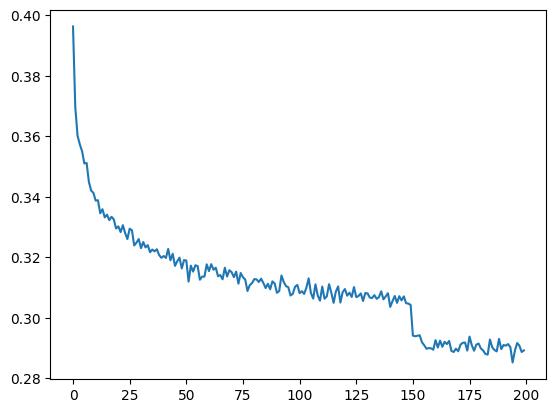

In [43]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

In [44]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [45]:
# using Evaluate the Loss 2 ... 
split_loss('train')
split_loss('val')

train 1.9185394048690796
val 2.0278823375701904


#### Sample from the model 2 (copied from a previous cell)

In [46]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:

        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, then break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

melan.
lynn.
gwosen.
macoy.
delik.
cloe.
sharth.
ayveer.
daarioiah.
jhreigh.
sebzy.
grayceline.
ellanda.
miliana.
hamaya.
woodlynh.
cardo.
alizan.
ronni.
sil.


Notice the names appear to be better because we have an increased block_size. 

#### Implementing WaveNet

Let's do a forward pass through the model and observe the shape of the tensors through each layer.

In [47]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # Let's look at a batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  5],
        [ 0,  0,  0,  0,  0,  0,  0, 21],
        [ 0,  0,  0,  0,  0, 16, 18,  9],
        [ 0,  0,  0,  0, 13,  1, 18,  9]])

In [48]:
#  Embedding(vocab_size, n_embd),
# output of the Embedding layer 
model.layers[0].out.shape 

torch.Size([4, 8, 10])

For each character in our embedding table, there is a n_embd = 10 dimensional vector that we are trying to learn. Recall our block_size = 8 which means we are using the previous 8 characters to predict the next character. So what the embedding layer does is pluck out the embedding vector for each one of the integers shown above, and loads it into a 3-dimensional 4x8x10 tensor.

In [49]:
# Flatten(),
# output of the flatten layer
model.layers[1].out.shape 

torch.Size([4, 80])

Passing through the Flatten layer will stretch out the 8 characters each expressed as a 10 dimensional embedding into one long tensor of length 80.

In [50]:
#  Linear(n_embd * block_size, n_hidden, bias=False),
# output of the Linear layer
model.layers[2].out.shape 

torch.Size([4, 200])

The Linear layer takes the 80 tensor and creates a n_hidden=200 channel tensor using matrix multiplication.

![](images/LinearLayer.png)

In [51]:
# an example of what happens in the linear layer using the dimensions of our current model ...
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [52]:
# but we don't have to use a (4,80) tensor ... we could also use, say, (4, 5, 80)
(torch.randn(4, 5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 200])

In [53]:
# or whatever ...
(torch.randn(4, 5, 20, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 20, 200])

You can see the matrix multiplication only works on the last tensor and the dimensions before it on the input tensor are left unchanged. (They are treated like a batch dimension)

In [54]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [55]:
# we can index like this to get all the even parts ...
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [56]:
# and we can index like this to get all the odd parts ...
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [57]:
# This is what Flatten currently does ...
e = torch.randn(4, 8, 10)
e.view(e.shape[0], -1).shape

torch.Size([4, 80])

In [58]:
# But we want this ... all the even characters
e[:, ::2, :]

tensor([[[-0.6289, -0.1188, -0.3832, -1.2141, -2.4001,  0.8368, -1.5430,
           0.7011, -0.4632,  0.0201],
         [-0.8997, -0.1984,  0.5939, -0.8595, -0.0312, -0.9459, -1.1669,
           1.7674,  0.7701, -0.4943],
         [ 0.4752, -0.7025, -0.3753, -1.6929, -2.3435,  0.6723, -1.9263,
          -0.5416,  0.0658, -0.3632],
         [ 1.1645, -1.0735, -1.7074, -0.8913, -0.7486, -0.3659,  0.7367,
           1.2411,  0.0882,  0.2409]],

        [[-0.2726, -0.9768,  1.6986, -1.0078, -0.4076, -2.2778, -0.6005,
          -0.1711, -0.0687, -1.3711],
         [ 0.9745,  0.6471, -0.5302,  0.6209,  1.1268, -1.2148,  1.3930,
           0.0835,  0.1536,  0.9886],
         [-0.4645,  0.0139,  0.9159,  0.4042,  1.4109,  1.0037, -0.3808,
          -0.3932,  1.6758,  0.4822],
         [-0.0329, -1.4869,  1.0128,  0.6575,  0.9171, -0.1974,  0.6926,
           0.9512,  0.2859, -1.1321]],

        [[ 1.0526, -0.9641,  0.3329,  0.0261,  1.0986, -1.3842, -0.2904,
          -0.8231,  1.0192, -0.1963

In [59]:
# all the odd characters
e[:,1::2,:]

tensor([[[-1.7495e+00, -1.5295e+00,  1.7552e-01, -1.1167e+00,  4.9832e-01,
          -8.8590e-01, -1.2320e-01, -8.9869e-01, -2.3719e-02, -5.9083e-01],
         [ 1.2137e+00,  9.1245e-04,  1.1874e-01,  9.4702e-03, -1.4502e+00,
          -1.2971e+00,  1.5337e+00, -1.1130e+00, -5.1656e-01, -1.5131e+00],
         [ 1.8093e+00,  8.9988e-01,  1.0926e+00, -6.9790e-01, -5.0996e-01,
          -2.3616e+00, -3.8196e-01, -5.4953e-01, -1.7670e+00, -2.0876e-01],
         [-2.3151e+00,  1.0608e-01, -1.3924e+00, -1.2161e+00, -6.4457e-01,
          -4.0051e-01, -1.1983e-02,  1.0753e+00,  2.5938e-01, -5.9821e-01]],

        [[-2.0530e-01,  1.6435e+00,  1.0229e+00, -1.6335e+00,  7.3915e-03,
          -2.4536e+00,  1.7649e+00,  4.0558e-01,  2.1267e-02,  3.0192e-01],
         [-9.1486e-01, -1.7660e-01, -5.9117e-01, -2.6395e-01, -7.2603e-01,
          -9.9896e-02,  7.1561e-01,  1.1587e-01,  1.1768e+00,  3.5015e-01],
         [ 5.2674e-01, -1.0877e+00,  3.2260e-01,  1.6910e+00, -2.1613e+00,
           1.8729

In [60]:
# doing this will give us what we want ...
explicit = torch.cat([e[:,::2,:],e[:,1::2,:]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

Turns out you don't need to do this, you can just view it how you want to shape it. 

In [61]:
e.view(4,4,20) == explicit

tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True]],

        [[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [T

In [62]:
# you can do this to see if all are True ... yeah, they are!
(e.view(4, 4, 20) == explicit).all()

tensor(True)

So let's redefine the Flatten layer. This code will deviate the PyTorch implementation, so let's give it a different name.

This class will only flatten some n consecutive elements and puts them into the last dimension.

In [63]:
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

And now we can redefine out model with this new layer.

In [64]:
model = Sequential([

    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size), 
    
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

In [65]:
# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22097


In [67]:
# run our previous example ...
ix = torch.randint(0, Xtr.shape[0], (4,)) # Let's look at a batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  3,  1, 12, 25],
        [ 0,  0,  0,  0,  0,  9, 18,  5],
        [ 0,  2,  1, 19, 20,  9,  5, 14],
        [ 0,  0,  0,  0,  0,  0, 13,  1]])

In [68]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


So here is our first attempt at a WaveNet like model:

In [69]:
model = Sequential([

    Embedding(vocab_size, n_embd),
    
    FlattenConsecutive(2),  Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

    Linear(n_hidden, vocab_size)
])

In [72]:
# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

170897


In [70]:
# run our previous example ...
ix = torch.randint(0, Xtr.shape[0], (4,)) # Let's look at a batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 26,  1,  8],
        [ 0,  0,  1, 12,  1,  9, 25,  1],
        [13,  1, 18,  9,  2,  5, 12, 12],
        [ 0,  0,  0,  0,  0,  0,  0,  3]])

In [71]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


![](images/WaveNet.png)

Our model conforms to the WaveNet model. Nice!

In the Karpathy video, he makes some tweaks to the model parameters:

In [73]:
n_embd = 10
n_hidden = 68

model = Sequential([

    Embedding(vocab_size, n_embd),
    
    FlattenConsecutive(2),  Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


So let's try to train this and see what we now get!

#### Training Loop 4 (copied from a previous cell)

In [74]:
%%time
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # 1) minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # 2) Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # 3) backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # 4) update using simple stochastic gradient descent
    lr = 0.1 if i < 150000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # 5) track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.6147
  10000/ 200000: 1.9339
  20000/ 200000: 2.1035
  30000/ 200000: 2.0178
  40000/ 200000: 1.7703
  50000/ 200000: 2.2595
  60000/ 200000: 2.3888
  70000/ 200000: 1.6692
  80000/ 200000: 2.0651
  90000/ 200000: 2.0445
 100000/ 200000: 1.9425
 110000/ 200000: 1.9986
 120000/ 200000: 2.2950
 130000/ 200000: 2.1001
 140000/ 200000: 2.0831
 150000/ 200000: 2.1945
 160000/ 200000: 1.8924
 170000/ 200000: 1.9899
 180000/ 200000: 1.6125
 190000/ 200000: 1.7678
CPU times: user 1h 53min 23s, sys: 30.6 s, total: 1h 53min 54s
Wall time: 16min 28s


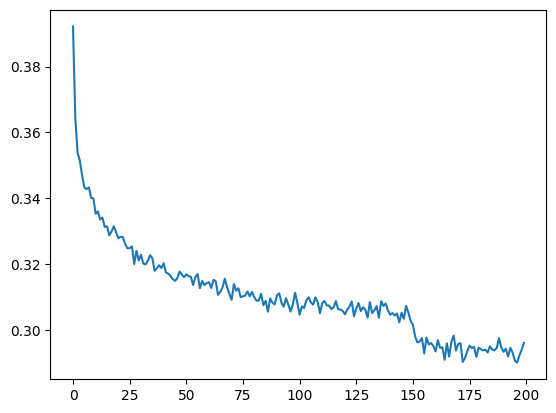

In [75]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

#### Evaluate the Loss 2 (copied from a previous cell)

In [76]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    logits = model(x)
    # loss = F.cross_entropy(x, y)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.9339561462402344
val 2.0239877700805664


It turns out we did not spend a lot of time figuring out an optimal selection of parameters for our model, and we also may have a bug in our BatchNorm1d layer. 